<a href="https://colab.research.google.com/github/TanmoyGG/CVPR/blob/main/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt

zip_path = '/content/animal_dataset.zip'
extract_path = '/content/animal_dataset_unzipped'

if os.path.exists(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Files unzipped successfully!")
else:
    print("Error: zip file not found. Make sure it's named 'animal_dataset.zip'")

Files unzipped successfully!


In [19]:
def simple_resize(image, target_h=32, target_w=32):
    orig_h, orig_w = image.shape[:2]
    y_indices = np.linspace(0, orig_h - 1, target_h).astype(int)
    x_indices = np.linspace(0, orig_w - 1, target_w).astype(int)
    resized_image = image[y_indices[:, None], x_indices]
    return resized_image

def rgb2gray(rgb_image):
    if len(rgb_image.shape) < 3: return rgb_image
    return np.dot(rgb_image[...,:3], [0.299, 0.587, 0.114])

#LOAD THE DATA
def load_dataset(base_path):
    X = []
    y = []

    dataset_root = base_path
    for root, dirs, files in os.walk(base_path):
        if 'cat' in dirs:
            dataset_root = root
            break

    classes = sorted([d for d in os.listdir(dataset_root) if os.path.isdir(os.path.join(dataset_root, d))])
    label_map = {class_name: i for i, class_name in enumerate(classes)}

    print(f"Classes found: {classes}")

    for class_name in classes:
        class_path = os.path.join(dataset_root, class_name)
        file_list = os.listdir(class_path)
        print(f"Processing {class_name}...")

        for img_name in file_list:
            img_path = os.path.join(class_path, img_name)
            try:
                img = plt.imread(img_path)

                #Resize and Grayscale
                img_resized = simple_resize(img, 32, 32)
                img_gray = rgb2gray(img_resized)

                #Flatten (32x32 = 1024)
                img_flat = img_gray.flatten()

                X.append(img_flat)
                y.append(label_map[class_name])
            except Exception as e:
                pass

    return np.array(X), np.array(y), classes


X, y, class_names = load_dataset(extract_path)

print("\n--- Final Check ---")
print(f"Total Images (X): {X.shape}")
print(f"Total Labels (y): {y.shape}")

Classes found: ['cat', 'dog', 'panda']
Processing cat...
Processing dog...
Processing panda...

--- Final Check ---
Total Images (X): (300, 1024)
Total Labels (y): (300,)


In [20]:
import numpy as np
import matplotlib.pyplot as plt

#DISTANCE FUNCTIONS ---
def calculate_distance(p1, p2, metric='L2'):

    if metric == 'L1':
        return np.sum(np.abs(p1 - p2))
    elif metric == 'L2':
        return np.sqrt(np.sum((p1 - p2)**2))
    return 0

In [21]:
#KNN PREDICTION ---
def knn_predict(X_train, y_train, X_test, k, metric):

    predictions = []

    for test_point in X_test:
        distances = []

        # Calculate distance from this test point to ALL training points
        for i in range(len(X_train)):
            dist = calculate_distance(test_point, X_train[i], metric)
            distances.append((dist, y_train[i]))

        # Sort by distance (smallest to largest) and take the top k
        distances.sort(key=lambda x: x[0])
        k_nearest = distances[:k]

        #labels of the k neighbors
        k_labels = [label for (_, label) in k_nearest]

        most_common = np.bincount(k_labels).argmax()
        predictions.append(most_common)

    return np.array(predictions)

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# CROSS-VALIDATION FUNCTION
def run_cross_validation_detailed(X, y, k_values):
    # Shuffle data indices first
    num_samples = len(X)
    indices = np.arange(num_samples)
    np.random.shuffle(indices)

    X_shuffled = X[indices]
    y_shuffled = y[indices]

    folds_X = np.array_split(X_shuffled, 5)
    folds_y = np.array_split(y_shuffled, 5)

    # Store ALL accuracies (not just averages)
    # This will be a list of lists. Example: [[0.3, 0.4, ...], [0.35, ...]]
    l1_all_accuracies = []
    l2_all_accuracies = []

    print("Starting Detailed Cross-Validation...")

    for k in k_values:
        fold_accuracies_L1 = []
        fold_accuracies_L2 = []

        for i in range(5):
            # Test set = fold i, Train set = everything else
            X_val = folds_X[i]
            y_val = folds_y[i]
            X_train = np.vstack([folds_X[j] for j in range(5) if j != i])
            y_train = np.concatenate([folds_y[j] for j in range(5) if j != i])

            # Manhattan (L1)
            preds_L1 = knn_predict(X_train, y_train, X_val, k, 'L1')
            acc_L1 = np.mean(preds_L1 == y_val)
            fold_accuracies_L1.append(acc_L1)

            # Euclidean (L2)
            preds_L2 = knn_predict(X_train, y_train, X_val, k, 'L2')
            acc_L2 = np.mean(preds_L2 == y_val)
            fold_accuracies_L2.append(acc_L2)

        # Append the list of 5 scores for this K
        l1_all_accuracies.append(fold_accuracies_L1)
        l2_all_accuracies.append(fold_accuracies_L2)

        avg_L1 = np.mean(fold_accuracies_L1)
        avg_L2 = np.mean(fold_accuracies_L2)
        print(f"K={k}: L1 Avg={avg_L1:.4f}, L2 Avg={avg_L2:.4f}")

    return l1_all_accuracies, l2_all_accuracies

# RUN EXPERIMENT AGAIN
k_values = range(1, 21, 2) # Odd numbers 1 to 20
l1_all_accuracies, l2_all_accuracies = run_cross_validation_detailed(X, y, k_values)




Starting Detailed Cross-Validation...
K=1: L1 Avg=0.3600, L2 Avg=0.3600
K=3: L1 Avg=0.3333, L2 Avg=0.3000
K=5: L1 Avg=0.3533, L2 Avg=0.3500
K=7: L1 Avg=0.4033, L2 Avg=0.3833
K=9: L1 Avg=0.4100, L2 Avg=0.3633
K=11: L1 Avg=0.4100, L2 Avg=0.3467
K=13: L1 Avg=0.3967, L2 Avg=0.3467
K=15: L1 Avg=0.3933, L2 Avg=0.3267
K=17: L1 Avg=0.3867, L2 Avg=0.3533
K=19: L1 Avg=0.3933, L2 Avg=0.3800


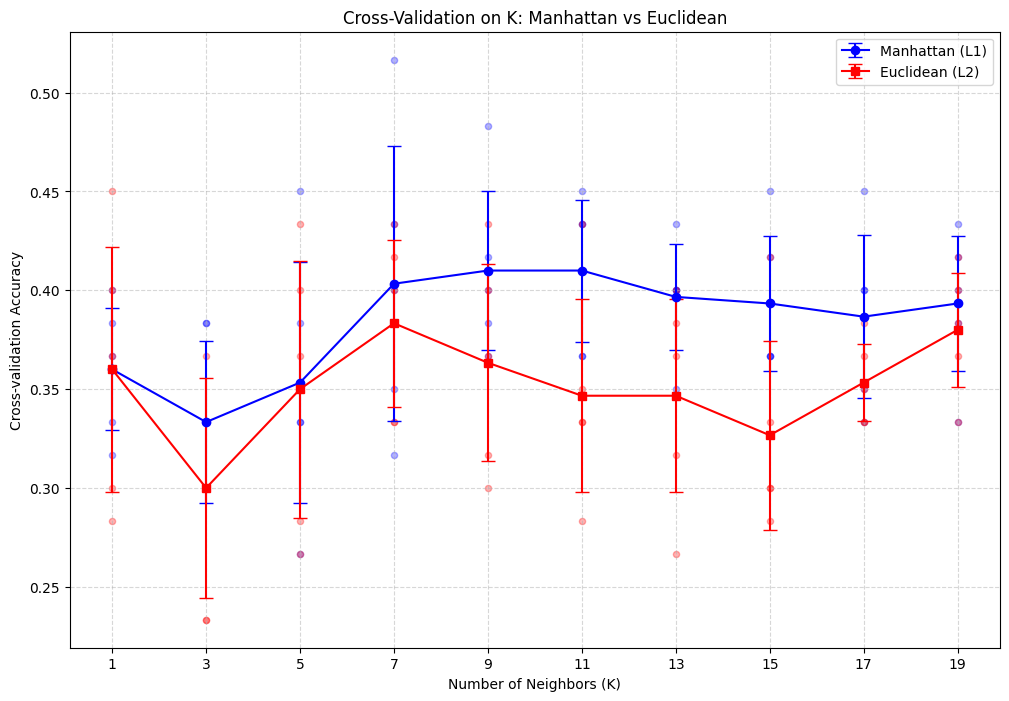

In [23]:
# ADVANCED PLOTTING (With Error Bars & Scatter)
# Calculate means and standard deviations
l1_means = [np.mean(acc) for acc in l1_all_accuracies]
l1_stds = [np.std(acc) for acc in l1_all_accuracies]

l2_means = [np.mean(acc) for acc in l2_all_accuracies]
l2_stds = [np.std(acc) for acc in l2_all_accuracies]

plt.figure(figsize=(12, 8))

# Plot L1 (Manhattan) with Error Bars
plt.errorbar(k_values, l1_means, yerr=l1_stds, fmt='-o', label='Manhattan (L1)', color='blue', capsize=5)

# Plot L2 (Euclidean) with Error Bars
plt.errorbar(k_values, l2_means, yerr=l2_stds, fmt='-s', label='Euclidean (L2)', color='red', capsize=5)

# Scatter plot: Show the individual 5 dots for every K
for i, k in enumerate(k_values):
    # Plot L1 dots (Blue, transparent)
    plt.scatter([k] * len(l1_all_accuracies[i]), l1_all_accuracies[i], color='blue', alpha=0.3, s=20)
    # Plot L2 dots (Red, transparent)
    plt.scatter([k] * len(l2_all_accuracies[i]), l2_all_accuracies[i], color='red', alpha=0.3, s=20)

plt.title('Cross-Validation on K: Manhattan vs Euclidean')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Cross-validation Accuracy')
plt.xticks(k_values)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

Auto-Selected Best Model: Metric=L1, K=9 (Accuracy: 0.4100)
--------------------------------------------------


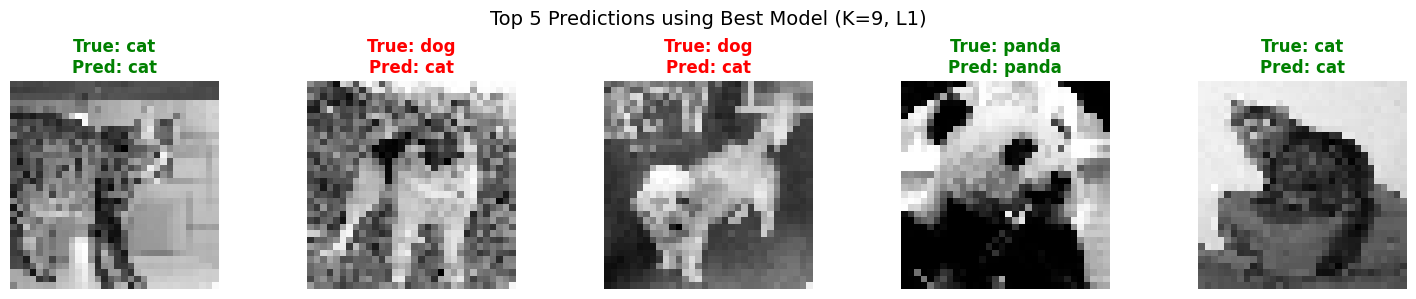

In [24]:
import random
import numpy as np
import matplotlib.pyplot as plt

# --- 1. RE-CALCULATE AVERAGES FROM THE DETAILED LISTS ---
# We need to compute the mean of each fold list to get the final accuracy per K
acc_L1 = [np.mean(folds) for folds in l1_all_accuracies]
acc_L2 = [np.mean(folds) for folds in l2_all_accuracies]

# --- 2. FIND THE BEST HYPERPARAMETERS AUTOMATICALLY ---
# Find the max accuracy in the L1 results
max_L1 = max(acc_L1)
index_L1 = np.argmax(acc_L1)
best_k_L1 = k_values[index_L1]

# Find the max accuracy in the L2 results
max_L2 = max(acc_L2)
index_L2 = np.argmax(acc_L2)
best_k_L2 = k_values[index_L2]

# Compare L1 vs L2 to find the ultimate winner
if max_L1 >= max_L2:
    BEST_METRIC = 'L1'
    BEST_K = best_k_L1
    best_acc = max_L1
else:
    BEST_METRIC = 'L2'
    BEST_K = best_k_L2
    best_acc = max_L2

print(f"Auto-Selected Best Model: Metric={BEST_METRIC}, K={BEST_K} (Accuracy: {best_acc:.4f})")
print("-" * 50)

# --- 3. PREPARE A MINI TEST ---
indices = list(range(len(X)))
random.shuffle(indices)
test_indices = indices[:5]
train_indices = indices[5:]

X_demo_train = X[train_indices]
y_demo_train = y[train_indices]
X_demo_test = X[test_indices]
y_demo_test = y[test_indices]

# --- 4. PREDICT ---
predictions = knn_predict(X_demo_train, y_demo_train, X_demo_test, BEST_K, BEST_METRIC)

# --- 5. VISUALIZE ---
plt.figure(figsize=(15, 3))

for i in range(5):
    plt.subplot(1, 5, i+1)

    image_2d = X_demo_test[i].reshape(32, 32)
    plt.imshow(image_2d, cmap='gray')

    true_label = class_names[y_demo_test[i]]
    pred_label = class_names[predictions[i]]

    color = 'green' if true_label == pred_label else 'red'

    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color, fontweight='bold')
    plt.axis('off')

plt.suptitle(f"Top 5 Predictions using Best Model (K={BEST_K}, {BEST_METRIC})", fontsize=14)
plt.tight_layout()
plt.show()

# Discussion

### 1. Performance Comparison: Manhattan (L1) vs. Euclidean (L2)
The results from the 5-fold cross-validation clearly demonstrate that the **Manhattan (L1)** distance metric is more suitable for this dataset than the Euclidean (L2) metric.

* **Best Performance:** The model achieved its highest average accuracy of **41.00%** using **Manhattan (L1)** distance at **K=9** and **K=11**.
* **Comparison Trends:** As shown in the graph, the L1 accuracy curve (blue line) consistently stays above the L2 accuracy curve (red line) for almost all values of K greater than 1. While L2 peaked at 38.33% (K=7), it failed to reach the 40% threshold that L1 maintained consistently between K=7 and K=11.

**Why did L1 win?**
In high-dimensional spaces (like our 1024-dimensional image vectors), **Euclidean distance (L2)** becomes sensitive to "outliers"—meaning a few pixels with very large brightness differences can disproportionately skew the distance calculation because those differences are squared. **Manhattan distance (L1)**, which simply sums the absolute differences, treats all pixel differences linearly. This makes L1 more robust to the noise and minor variations present in raw image data.

### 2. Dataset Characteristics and Class Complexity
The relatively low overall accuracy (~41%) can be attributed to the specific nature of the dataset and preprocessing:

* **Loss of Color Information:** Converting images to grayscale removes critical distinguishing features. For example, the stark black-and-white contrast of a **Panda** is its most defining feature. In grayscale, a black-and-white cat or a shadowed dog can look statistically very similar to a panda.
* **Low Resolution (32x32):** At 32x32 pixels, fine details (like eye shape or fur texture) are lost. The model is essentially looking at "blurry blobs."
* **Raw Pixel Features:** We used raw pixel intensities as features. This method is brittle; if an object is shifted slightly to the left or right, the pixel-to-pixel distance changes dramatically, confusing the k-NN algorithm.

### 3. Limitations and Future Improvements
The primary limitation of this study is the feature extraction method. k-NN on raw pixels is rarely sufficient for complex object recognition.

**Potential Improvements:**
1.  **Feature Extraction:** Instead of using raw pixels, we could extract **HOG (Histogram of Oriented Gradients)** features. HOG focuses on the *structure* and *edges* of the object (e.g., the shape of the ears) rather than the brightness of specific pixels, making it robust to position shifts.
2.  **Advanced Algorithms:** A **Convolutional Neural Network (CNN)** would significantly outperform k-NN. CNNs are designed to automatically learn spatial hierarchies (edges -> shapes -> objects) and are invariant to translation, meaning they can recognize a cat whether it is in the center of the image or the corner.